# Indenter Tutorial

In [1]:
# Change to project root (parent directory) This step is necessary to ensure that the script runs from the correct context.
%cd ..

from pathlib import Path

# Check if current directory is 'indenter'
if Path.cwd().name != "indenter":
    print("Error: You are not in the project root directory.")
    print("Please change to the project root directory and try again.")

/Users/cacar/Desktop/University Documents and Books/Utrecht-Uni-Master-Applied-Data-Science/Thesis/indenter


## Installation

If you already have `indenter` installed, you can skip this step.

In [2]:
!python3 -m pip install --upgrade pip
!pip uninstall indenter -y
!python3 -m pip install -e .

Found existing installation: indenter 0.1.0
Uninstalling indenter-0.1.0:
  Successfully uninstalled indenter-0.1.0
Obtaining file:///Users/cacar/Desktop/University%20Documents%20and%20Books/Utrecht-Uni-Master-Applied-Data-Science/Thesis/indenter
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for indenter (pyproject.toml) ... done
  Created wheel for indenter: filename=indenter-0.1.0-0.editable-py3-none-any.whl size=16980 sha256=ac1f0f8dfd1e2085946cd16034344573463f8139f0c97228cbddd85087f11490
  Stored in directory: /private/var/folders/bg/vndfz9xx467c3blfn0k7mlbc0000gn/T/pip-ephem-wheel-cache-akelr304/wheels/d3/f7/24/769af5f57e89ac9039ab28476cada7790c186ac43d65db2497
Successfully built indenter


## Import Packages

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from pathlib import Path

from indenter.load_datasets import load_txt, load_tdm
from indenter.preprocess import default_preprocess
from indenter.locate import (
    default_locate,
    detect_popins_iforest,
    detect_popins_cnn,
    detect_popins_fd_fourier,
    detect_popins_savgol
)

2025-05-29 15:42:31.573373: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Raw Data

In [4]:
# 2.1 Point this at one of your .txt measurement files
txt_path = Path("datasets/6microntip_slowloading/grain9_6um_indent03_HL_QS_LC.txt")
df = load_txt(txt_path)

# 2.2 Peek at the first few rows
df.head()


[WARNING] UTF-8 decode failed for datasets/6microntip_slowloading/grain9_6um_indent03_HL_QS_LC.txt, falling back to Latin-1
[INFO] Loaded TXT data grain9_6um_indent03_HL_QS_LC.txt: 16391 × 3


,Depth (nm),Load (µN),Time (s)
0,27.553054,1970.863069,0.000000
1,27.699882,2057.642476,0.005005
2,27.409630,2105.476271,0.010010
3,27.550630,2050.874908,0.015014
4,27.360660,2041.534181,0.020019


In [5]:
# 2.3 Metadata on the txt file
print("Timestamp:   ", df.attrs["timestamp"])
print("Num points:  ", df.attrs["num_points"])

Timestamp:    Wed Apr 16 11:27:39 2025
Num points:   16391


## Load TDM Metadata

In [6]:
tdm_meta_file = Path("datasets/6microntip_slowloading/grain1_6um_indent01_HL_QS_LC.tdm")
df_tdm_meta_root, df_tdm_meta_channels = load_tdm(tdm_meta_file)

[INFO] Loaded TDM metadata grain1_6um_indent01_HL_QS_LC.tdm: 47 channels


In [7]:
df_tdm_meta_root.head()

,root_name,root_description,root_title,root_author,Acquisition_Actuation_Gain,Acquisition_Actuation_Percentage,Acquisition_Adaptive_FB_Gain,Acquisition_ADC0_Offset__V__,Acquisition_ADC3_Offset__V__,Acquisition_Area_Function_Name,...,Uncertainty_Quasi_Analysis_Force_Shift__µN__,Uncertainty_Quasi_Analysis_Hardness__GPa__,Uncertainty_Quasi_Analysis_Indentation_Modulus__GPa__,Uncertainty_Quasi_Analysis_Martens_Area__nm~nm__,Uncertainty_Quasi_Analysis_Martens_Hardness__GPa__,Uncertainty_Quasi_Analysis_Max_Depth_For_Hardness__nm__,Uncertainty_Quasi_Analysis_Max_Fitted_Depth__nm__,Uncertainty_Quasi_Analysis_Max_Force__µN__,Uncertainty_Quasi_Analysis_Max_Force_For_Hardness__µN__,Uncertainty_Quasi_Analysis_Reduced_Modulus__GPa__
0,Hysitron Data File,Quasi-static Test Data,Hysitron Data File,localadmin,15,0.00301045850968697,0.5,-3.53889723777893,5.68998800731816,newHLConi6_TAF_10-04-25_MCA2_TAF2_MC0550.ara,...,105.757206912521,0,0,0,0,0,0,0,0,0


As we can see the metadata root data have 368 columns we can transpose it to have a better view of the data.

In [8]:
df_tdm_meta_root = df_tdm_meta_root.T.reset_index()
df_tdm_meta_root.columns = ['attribute', 'value']

In [9]:
# Let's take a look at the first 10 rows of the metadata root DataFrame
df_tdm_meta_root.head(10)

,attribute,value
0,root_name,Hysitron Data File
1,root_description,Quasi-static Test Data
2,root_title,Hysitron Data File
3,root_author,localadmin
4,Acquisition_Actuation_Gain,15
5,Acquisition_Actuation_Percentage,0.00301045850968697
6,Acquisition_Adaptive_FB_Gain,0.5
7,Acquisition_ADC0_Offset__V__,-3.53889723777893
8,Acquisition_ADC3_Offset__V__,5.68998800731816
9,Acquisition_Area_Function_Name,newHLConi6_TAF_10-04-25_MCA2_TAF2_MC0550.ara


In [10]:
# Metadata channels
df_tdm_meta_channels.head(50)

,group,channel_id,name,unit,description,datatype,sequence_id
0,Indentation All Data Points,usi59,Test Time,s,Test Time,DT_DOUBLE,usi1
1,Indentation Averaged Values,usi60,Test Time,s,Test Time,DT_DOUBLE,usi2
2,Indentation Standard Deviation Values,usi61,Test Time,s,Test Time,DT_DOUBLE,usi3
3,Indentation All Data Points,usi62,Indent Disp.,nm,Indent Displacement,DT_DOUBLE,usi4
4,Indentation Averaged Values,usi63,Indent Disp.,nm,Indent Displacement,DT_DOUBLE,usi5
5,Indentation Standard Deviation Values,usi64,Indent Disp.,nm,Indent Displacement,DT_DOUBLE,usi6
6,Indentation All Data Points,usi65,Indent Load,µN,Indent Load,DT_DOUBLE,usi7
7,Indentation Averaged Values,usi66,Indent Load,µN,Indent Load,DT_DOUBLE,usi8
8,Indentation Standard Deviation Values,usi67,Indent Load,µN,Indent Load,DT_DOUBLE,usi9
9,Indentation All Data Points,usi68,Indent Disp. Volt.,V,Indent Displacement Voltage,DT_DOUBLE,usi10


## Preprocess Data

In [11]:
# 4.1 Apply the default preprocessing pipeline
df_pre = default_preprocess(df)

# 4.2 Inspect result
df_pre.head()

[INFO] Removed first 808 points up to minimum Load (-123.05)
[INFO] Auto-rescaled at index 687, load=146.43 > 127.88, shift=6.8 nm
[INFO] Flagged contact point at index 687
[INFO] Removed 687 rows before contact point (Depth < 0)


,Depth (nm),Load (µN),Time (s),contact_point
0,0.000000,175.206294,9.958208,True
1,1.498740,204.902582,9.968205,False
2,3.108329,261.286045,9.978202,False
3,4.590940,378.618504,9.988199,False
4,6.165765,489.429839,9.998195,False


### Plot Raw vs Preprocessed Data

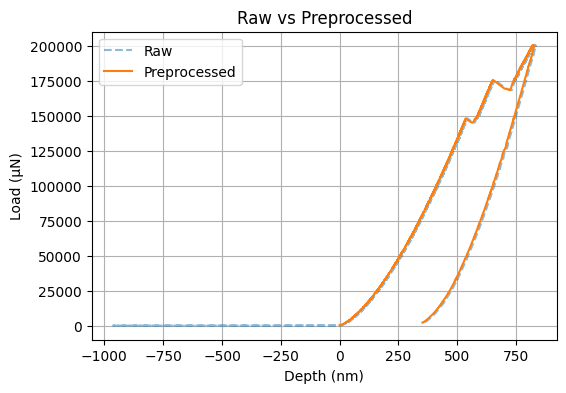

In [12]:
# 4.3 Plot Raw vs Preprocessed
plt.figure(figsize=(6,4))
plt.plot(df["Depth (nm)"], df["Load (µN)"], '--', alpha=0.5, label="Raw")
plt.plot(df_pre["Depth (nm)"], df_pre["Load (µN)"], '-', label="Preprocessed")
plt.xlabel("Depth (nm)")
plt.ylabel("Load (µN)")
plt.title("Raw vs Preprocessed")
plt.legend()
plt.grid(True)
plt.show()


## Pop-in Detection

### Isolation Forest

In [13]:
df_if = detect_popins_iforest(df_pre, random_state=42)

[INFO] IsolationForest flagged 15 anomalies


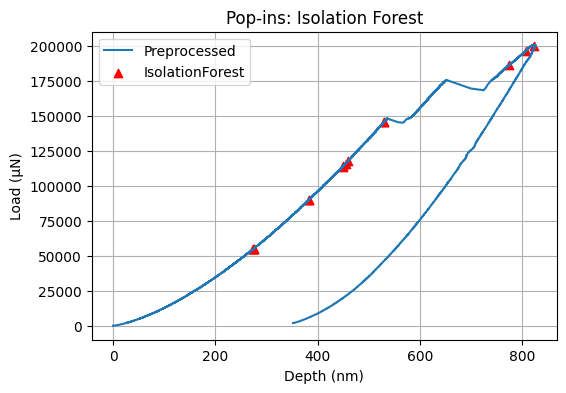

In [14]:
plt.figure(figsize=(6,4))
plt.plot(df_pre["Depth (nm)"], df_pre["Load (µN)"], label="Preprocessed")
plt.scatter(df_if.loc[df_if["popin_iforest"], "Depth (nm)"],
            df_if.loc[df_if["popin_iforest"], "Load (µN)"],
            c='r', label="IsolationForest", marker='^')
plt.title("Pop-ins: Isolation Forest")
plt.xlabel("Depth (nm)"); plt.ylabel("Load (µN)")
plt.legend(); plt.grid(True); plt.show()

### CNN Autoencoder

In [15]:
df_cnn = detect_popins_cnn(df_pre)

[INFO] CNN flagged 149 anomalies


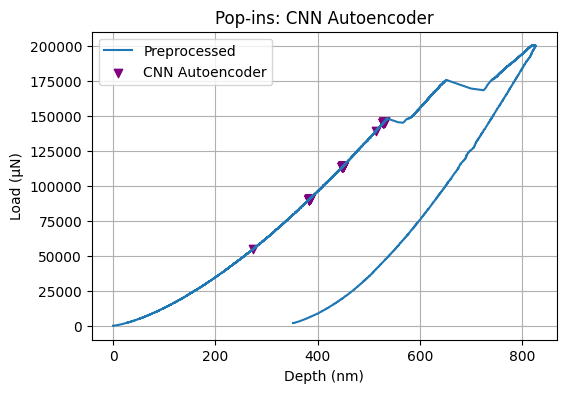

In [16]:
plt.figure(figsize=(6,4))
plt.plot(df_pre["Depth (nm)"], df_pre["Load (µN)"], label="Preprocessed")
plt.scatter(df_cnn.loc[df_cnn["popin_cnn"], "Depth (nm)"],
            df_cnn.loc[df_cnn["popin_cnn"], "Load (µN)"],
            c='purple', label="CNN Autoencoder", marker='v')
plt.title("Pop-ins: CNN Autoencoder")
plt.xlabel("Depth (nm)"); plt.ylabel("Load (µN)")
plt.legend(); plt.grid(True); plt.show()

### Finite Difference

In [17]:
df_fd = detect_popins_fd_fourier(df_pre)

[INFO] Fourier spectral method flagged 31 anomalies


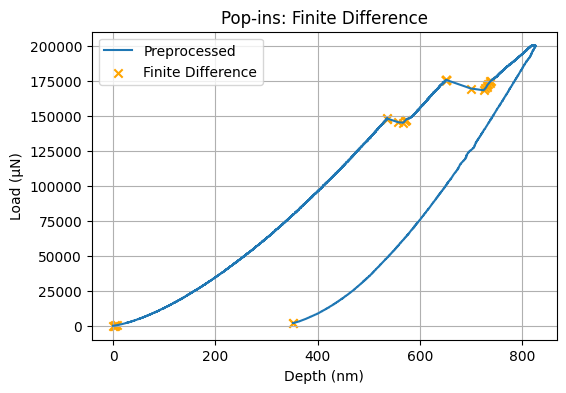

In [18]:
plt.figure(figsize=(6,4))
plt.plot(df_pre["Depth (nm)"], df_pre["Load (µN)"], label="Preprocessed")
plt.scatter(df_fd.loc[df_fd["popin_fd"], "Depth (nm)"],
            df_fd.loc[df_fd["popin_fd"], "Load (µN)"],
            c='orange', label="Finite Difference", marker='x')
plt.title("Pop-ins: Finite Difference")
plt.xlabel("Depth (nm)"); plt.ylabel("Load (µN)")
plt.legend(); plt.grid(True); plt.show()

### Savitzky-Golay Derivative

In [19]:
df_sg = detect_popins_savgol(df_pre)

[INFO] Savitzky-Golay flagged 35 anomalies


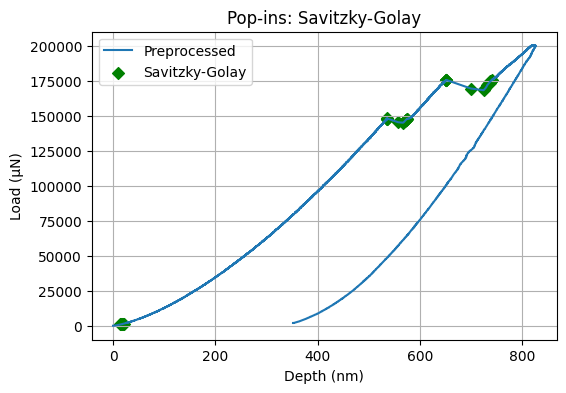

In [20]:
plt.figure(figsize=(6,4))
plt.plot(df_pre["Depth (nm)"], df_pre["Load (µN)"], label="Preprocessed")
plt.scatter(df_sg.loc[df_sg["popin_savgol"], "Depth (nm)"],
            df_sg.loc[df_sg["popin_savgol"], "Load (µN)"],
            c='green', label="Savitzky-Golay", marker='D')
plt.title("Pop-ins: Savitzky-Golay")
plt.xlabel("Depth (nm)"); plt.ylabel("Load (µN)")
plt.legend(); plt.grid(True); plt.show()

### All Methods Combined

In [21]:
df_loc = default_locate(df_pre)

[INFO] IsolationForest flagged 14 anomalies
[INFO] CNN flagged 142 anomalies
[INFO] Fourier spectral method flagged 31 anomalies
[INFO] Savitzky-Golay flagged 35 anomalies
[INFO] Total pop-ins detected by selected methods: 199


In [22]:
df_loc.head()

,Depth (nm),Load (µN),Time (s),contact_point,popin_iforest,popin_cnn,popin_fd,popin_savgol,popin,popin_methods,popin_score,popin_confident
0,0.000000,175.206294,9.958208,True,False,False,True,False,True,fd,1,False
1,1.498740,204.902582,9.968205,False,False,False,True,False,True,fd,1,False
2,3.108329,261.286045,9.978202,False,False,False,True,False,True,fd,1,False
3,4.590940,378.618504,9.988199,False,False,False,True,False,True,fd,1,False
4,6.165765,489.429839,9.998195,False,False,False,False,False,False,,0,False


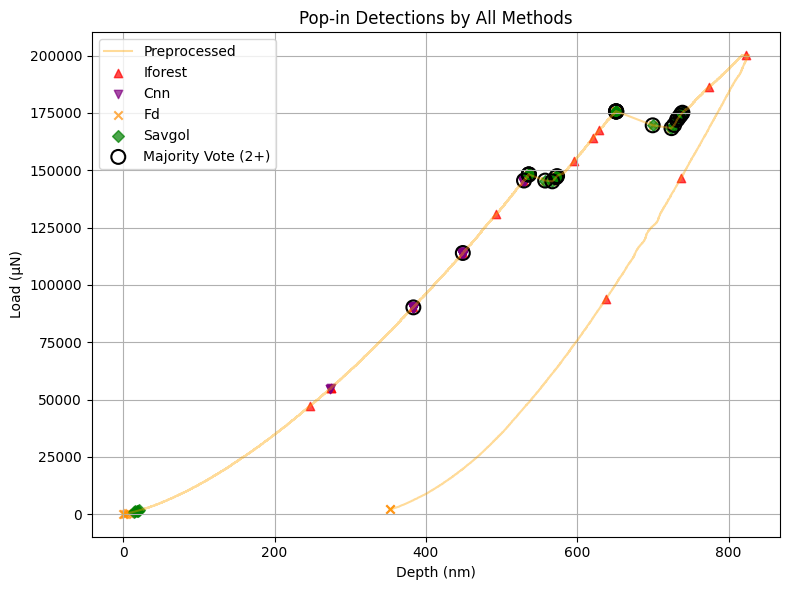

In [23]:
plt.figure(figsize=(8,6))
plt.plot(df_loc["Depth (nm)"], df_loc["Load (µN)"], label="Preprocessed", alpha=0.4, color='orange')

# Color-coded method detections
colors = {
    "popin_iforest": 'red',
    "popin_cnn": 'purple',
    "popin_fd": 'darkorange',
    "popin_savgol": 'green'
}
markers = {
    "popin_iforest": '^',
    "popin_cnn": 'v',
    "popin_fd": 'x',
    "popin_savgol": 'D'
}

for method, color in colors.items():
    mdf = df_loc[df_loc[method]]
    plt.scatter(mdf["Depth (nm)"], mdf["Load (µN)"],
                c=color, label=method.replace("popin_", "").capitalize(),
                marker=markers[method], alpha=0.7)

# Highlight confident detections
confident = df_loc[df_loc["popin_confident"]]
plt.scatter(confident["Depth (nm)"], confident["Load (µN)"],
            edgecolors='k', facecolors='none', label="Majority Vote (2+)", s=100, linewidths=1.5)

plt.xlabel("Depth (nm)"); plt.ylabel("Load (µN)")
plt.title("Pop-in Detections by All Methods")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

#### Default Locate More Strict Threshold

In [24]:
# 1. Tighter thresholds (more sensitive, may yield more false positives)
df_loc_strict = default_locate(
    df_pre,
    iforest_contamination=0.002,     # higher contamination → more anomalies
    cnn_threshold_multiplier=3.0,    # lower multiplier → more CNN anomalies
    fd_threshold=2.0,                # lower std threshold for FD
    savgol_threshold=2.0             # lower std threshold for Savitzky-Golay
)

[INFO] IsolationForest flagged 30 anomalies
[INFO] CNN flagged 312 anomalies
[INFO] Fourier spectral method flagged 151 anomalies
[INFO] Savitzky-Golay flagged 2018 anomalies
[INFO] Total pop-ins detected by selected methods: 2373


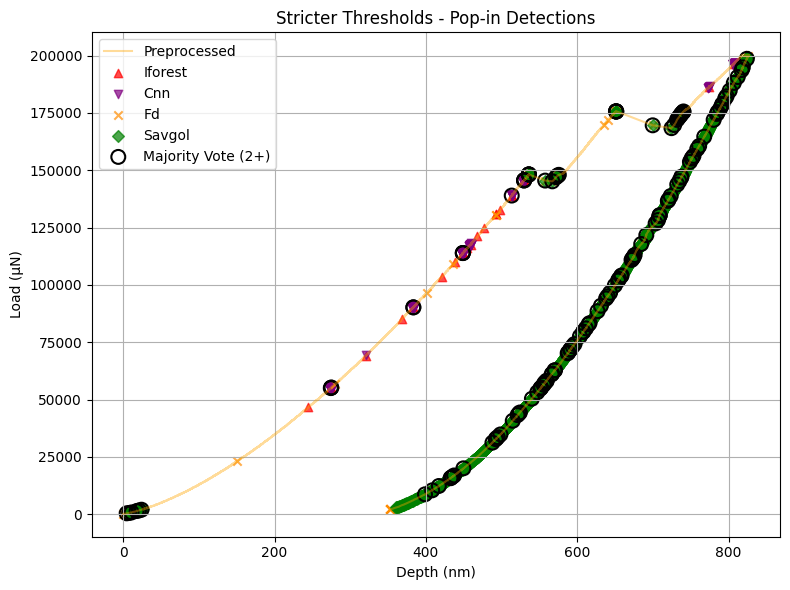

In [25]:
plt.figure(figsize=(8,6))
plt.plot(df_loc_strict["Depth (nm)"], df_loc_strict["Load (µN)"], label="Preprocessed", alpha=0.4, color='orange')

colors = {
    "popin_iforest": 'red',
    "popin_cnn": 'purple',
    "popin_fd": 'darkorange',
    "popin_savgol": 'green'
}
markers = {
    "popin_iforest": '^',
    "popin_cnn": 'v',
    "popin_fd": 'x',
    "popin_savgol": 'D'
}

for method, color in colors.items():
    mdf = df_loc_strict[df_loc_strict[method]]
    plt.scatter(mdf["Depth (nm)"], mdf["Load (µN)"],
                c=color, label=method.replace("popin_", "").capitalize(),
                marker=markers[method], alpha=0.7)

confident = df_loc_strict[df_loc_strict["popin_confident"]]
plt.scatter(confident["Depth (nm)"], confident["Load (µN)"],
            edgecolors='k', facecolors='none', label="Majority Vote (2+)", s=100, linewidths=1.5)

plt.xlabel("Depth (nm)"); plt.ylabel("Load (µN)")
plt.title("Stricter Thresholds - Pop-in Detections")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

#### Default Locate More Lenient Threshold

In [26]:
# 2. Looser thresholds (more conservative)
df_loc_loose = default_locate(
    df_pre,
    iforest_contamination=0.0005,
    cnn_threshold_multiplier=6.0,
    fd_threshold=4.0,
    savgol_threshold=4.0
)

[INFO] IsolationForest flagged 7 anomalies
[INFO] CNN flagged 98 anomalies
[INFO] Fourier spectral method flagged 24 anomalies
[INFO] Savitzky-Golay flagged 26 anomalies
[INFO] Total pop-ins detected by selected methods: 137


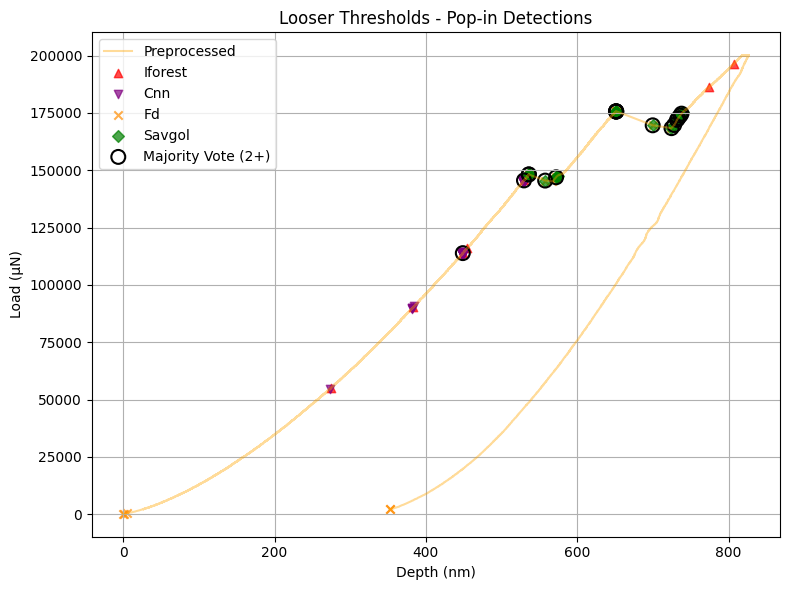

In [27]:
plt.figure(figsize=(8,6))
plt.plot(df_loc_loose["Depth (nm)"], df_loc_loose["Load (µN)"], label="Preprocessed", alpha=0.4, color='orange')

for method, color in colors.items():
    mdf = df_loc_loose[df_loc_loose[method]]
    plt.scatter(mdf["Depth (nm)"], mdf["Load (µN)"],
                c=color, label=method.replace("popin_", "").capitalize(),
                marker=markers[method], alpha=0.7)

confident = df_loc_loose[df_loc_loose["popin_confident"]]
plt.scatter(confident["Depth (nm)"], confident["Load (µN)"],
            edgecolors='k', facecolors='none', label="Majority Vote (2+)", s=100, linewidths=1.5)

plt.xlabel("Depth (nm)"); plt.ylabel("Load (µN)")
plt.title("Looser Thresholds - Pop-in Detections")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

#### Comparison of Looser and Stricter Thresholds

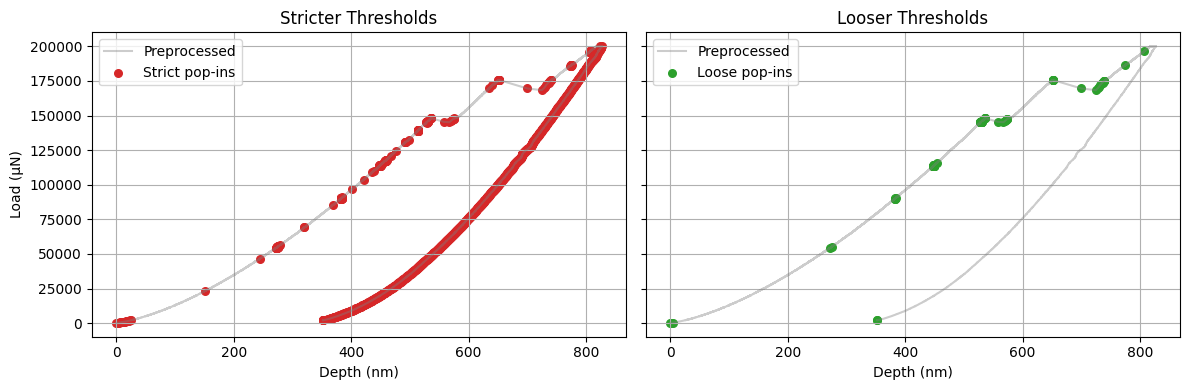

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot strict
ax[0].plot(df_pre["Depth (nm)"], df_pre["Load (µN)"], color="gray", alpha=0.4, label="Preprocessed")
ax[0].scatter(df_loc_strict[df_loc_strict["popin"]]["Depth (nm)"],
              df_loc_strict[df_loc_strict["popin"]]["Load (µN)"],
              c="C3", s=30, label="Strict pop-ins")
ax[0].set_title("Stricter Thresholds")
ax[0].set_xlabel("Depth (nm)")
ax[0].set_ylabel("Load (µN)")
ax[0].legend()
ax[0].grid(True)

# Plot loose
ax[1].plot(df_pre["Depth (nm)"], df_pre["Load (µN)"], color="gray", alpha=0.4, label="Preprocessed")
ax[1].scatter(df_loc_loose[df_loc_loose["popin"]]["Depth (nm)"],
              df_loc_loose[df_loc_loose["popin"]]["Load (µN)"],
              c="C2", s=30, label="Loose pop-ins")
ax[1].set_title("Looser Thresholds")
ax[1].set_xlabel("Depth (nm)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


### Locate Without Preprocessing

In [29]:
df_loc_without_preprocessing = default_locate(df)

[INFO] IsolationForest flagged 17 anomalies
[INFO] CNN flagged 153 anomalies
[INFO] Fourier spectral method flagged 29 anomalies
[INFO] Savitzky-Golay flagged 37 anomalies
[INFO] Total pop-ins detected by selected methods: 213


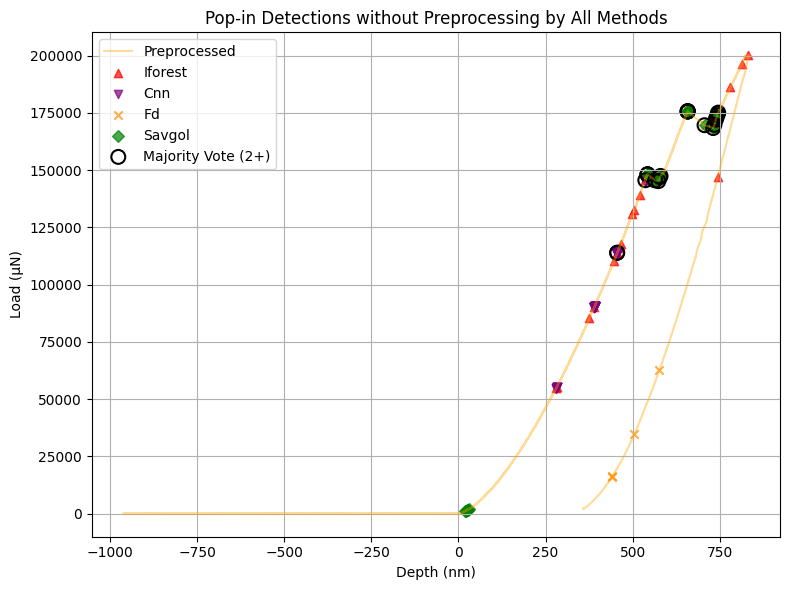

In [31]:
plt.figure(figsize=(8,6))
plt.plot(df_loc_without_preprocessing["Depth (nm)"], df_loc_without_preprocessing["Load (µN)"], label="Preprocessed", alpha=0.4, color='orange')

# Color-coded method detections
colors = {
    "popin_iforest": 'red',
    "popin_cnn": 'purple',
    "popin_fd": 'darkorange',
    "popin_savgol": 'green'
}
markers = {
    "popin_iforest": '^',
    "popin_cnn": 'v',
    "popin_fd": 'x',
    "popin_savgol": 'D'
}

for method, color in colors.items():
    mdf = df_loc_without_preprocessing[df_loc_without_preprocessing[method]]
    plt.scatter(mdf["Depth (nm)"], mdf["Load (µN)"],
                c=color, label=method.replace("popin_", "").capitalize(),
                marker=markers[method], alpha=0.7)

# Highlight confident detections
confident = df_loc_without_preprocessing[df_loc_without_preprocessing["popin_confident"]]
plt.scatter(confident["Depth (nm)"], confident["Load (µN)"],
            edgecolors='k', facecolors='none', label="Majority Vote (2+)", s=100, linewidths=1.5)

plt.xlabel("Depth (nm)"); plt.ylabel("Load (µN)")
plt.title("Pop-in Detections without Preprocessing by All Methods")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()